In [1]:
import pandas as pd
import os
import json
import math
import random
import numpy as np
from scipy.io import loadmat
from scipy import signal
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import  PCA
import seaborn as sns

# CA PT2

In [2]:
def get_speedup_reason(trip_name, speedup_index):
    info_path = "C:/git/kdp_hlb_evalframework/_temp/driving_event_window_info/" + trip_name + "_info.json"
    with open(info_path, 'r') as open_file:
        read_list = json.load(open_file)
    for window_dict in read_list:
        if window_dict['data'] == 'speed_up'+str(speedup_index)+'.csv':
            return window_dict['driving_event_reason']

In [3]:
def speedup_length_filter(trip_name, speedup_index):
    MAX_SPEEDUP_LENGTH = 750
    info_path = "C:/git/kdp_hlb_evalframework/_temp/driving_event_window_info/" + trip_name + "_info.json"
    with open(info_path, 'r') as open_file:
        read_list = json.load(open_file)
    for window_dict in read_list:
        if window_dict['data'] == 'speed_up'+str(speedup_index)+'.csv':
            length = int(window_dict['length'])
            if length > MAX_SPEEDUP_LENGTH:
                return False
            else:
                return True

In [4]:
def get_ca_pt2_parameters(start, end, mat_dict, trip_infos):
    parameters_df = pd.DataFrame(columns=["trip_name", "speedup_index", "driver_id", "velocity_class", "highway_driving", "D", "w0", "tc", "alfa", "t_delay"])
    velocity_classes = ["zero_to_low_speed_up", "zero_to_mid_speed_up", "zero_to_high_speed_up",
                "low_to_low_speed_up", "low_to_mid_speed_up", "low_to_high_speed_up",
                "mid_to_mid_speed_up", "mid_to_high_speed_up", "high_to_high_speed_up",
                ]
    end = min(end, trip_infos.shape[0])
    for i in range(start, end):
        number_of_speedups = trip_infos['number_of_speedups'][i]
        trip_name = trip_infos['trip_name'][i]
        driver_id = trip_infos['subject_id'][i]
        for j in range(number_of_speedups-1):
            parameter_string = "trip{index}_speedup_{speedup_index}_parameter".format(index = i, speedup_index = j)
            parameters = mat_dict[parameter_string][0]
            reasons = get_speedup_reason(trip_name=trip_name, speedup_index=j)
            velocity_class = "unknown"
            highway_driving = False
            for reason in reasons:
                if reason in velocity_classes:
                    velocity_class = reason 
            if "highway_driving" in reasons:
                highway_driving = True
            #parameters are [K, w0, D] 
            # speedups that are too long or have a "turn" reason are removed from the analyzed dataset
            if not "turn" in reasons and speedup_length_filter(trip_name=trip_name, speedup_index=j):
                parameters_df.loc[-1] = [trip_name, j, driver_id, velocity_class, highway_driving, parameters[0], parameters[1], parameters[2], parameters[3],parameters[4]]
                parameters_df.index = parameters_df.index + 1
    return parameters_df

In [5]:
def get_ca_pt2_element(ca_pt2_parameters, U):
    # returns output value based on time = U
    D = ca_pt2_parameters[0]
    T = 1/ca_pt2_parameters[1]
    tc = ca_pt2_parameters[2]
    alfa = ca_pt2_parameters[3]
    tdelay = ca_pt2_parameters[4]
    v0 = alfa*tc
    G = 1

    if U < tdelay:
        Y = 0
    elif U < (tc+tdelay):
        Y = alfa*(U-tdelay)
    else:
        t = U-tc-tdelay
        if D > 1:
            l1 = (-D+np.sqrt(D**2-1))/T
            l2 = (-D-np.sqrt(D**2-1))/T
            c1 = (v0-G)*(l2-alfa)/(l2-l1)
            c2 = (alfa-l1*(v0-G))/(l2-l1)
            Y = c1*np.exp(l1*t) + c2*np.exp(l2*t) + G
        elif D == 1:
            l = -1/T
            c1 = v0-G
            c2 = alfa - l*(v0-G)
            Y = c1*np.exp(l*t) + c2*t*np.exp(l*t) + G
        else:
            A = -D/T
            B = np.sqrt(1-D**2)/T
            c1 = v0-G
            c2 = (alfa-A*(v0-G))/B
            Y = np.exp(A*t)*(c1*np.cos(B*t) + c2*np.sin(B*t)) + G

    return Y

In [6]:
def get_ca_pt2_signal(data_path, trip_name, speedup_index, ca_pt2_parameters_df, signal_profile):
    #getting time signal
    data_df = pd.read_csv(os.path.join(data_path, trip_name, "speed_up{index}.csv".format(index = speedup_index)))
    time = data_df[signal_profile["Time"]].values-data_df[signal_profile["Time"]].values[0]

    #getting parameters
    speedup_df = ca_pt2_parameters_df.loc[(ca_pt2_parameters_df.trip_name == trip_name) & (ca_pt2_parameters_df.speedup_index == speedup_index)]
    ca_pt2_parameters = [float(speedup_df.D.values), float(speedup_df.w0.values), float(speedup_df.tc.values), float(speedup_df.alfa.values), float(speedup_df.t_delay.values)]
    #getting signal
    y_ca_pt2 = []
    for i, time_point in enumerate(list(time)):
        Y = get_ca_pt2_element(ca_pt2_parameters=ca_pt2_parameters, U=time_point)
        y_ca_pt2.append(Y)
    return time, y_ca_pt2, ca_pt2_parameters

In [7]:
def get_velocity_signal(data_path, trip_name, speedup_index, signal_profile):
    data_df = pd.read_csv(os.path.join(data_path, trip_name, "speed_up{index}.csv".format(index = speedup_index)))
    y = data_df[signal_profile["Longitudinal_Velocity"]].values
    t = data_df[signal_profile["Time"]].values-data_df[signal_profile["Time"]].values[0]
    y_norm = (y - y[0]) / (y[len(y)-1] - y[0])
    return t, y_norm

In [8]:
def get_auc_difference_integral(y_real, y_ca_pt2):
    min_signal = abs(y_ca_pt2-y_real)
    trapz_integral = np.trapz(min_signal, dx=1)
    return trapz_integral

In [9]:
def accuracy_difference(data_path, trip_name, speedup_index, ca_pt2_parameters_df, signal_profile):
    t_real, y_real = get_velocity_signal(data_path, trip_name, speedup_index, signal_profile)
    t_ca_pt2, y_ca_pt2, ca_pt2_parameters = get_ca_pt2_signal(data_path, trip_name, speedup_index, ca_pt2_parameters_df, signal_profile)
    padding_length_ca_pt2 = math.floor(0.25*len(y_ca_pt2))
    y_ca_pt2 = np.pad(y_ca_pt2, (padding_length_ca_pt2, padding_length_ca_pt2), mode='edge')
    padding_length_real = math.floor(0.25*len(y_real))
    y_real = np.pad(y_real, (padding_length_real, padding_length_real), mode='edge')
    y_ca_pt2 = signal.resample(y_ca_pt2, 150)
    y_real = signal.resample(y_real, 150)
    padding_length_reduced = 25
    y_ca_pt2 = y_ca_pt2[padding_length_reduced:len(y_ca_pt2)-padding_length_reduced]
    y_real = y_real[padding_length_reduced:len(y_real)-padding_length_reduced]
    trapz_auc = get_auc_difference_integral(y_real, y_ca_pt2)
    t_display = np.arange(0,100)
    return t_display, y_real, y_ca_pt2, trapz_auc, ca_pt2_parameters

In [10]:
input_postfix = "CA_PT2_2023_07_31" #"_jp_extreme_experiment" 
output_postfix = "CA_PT2_2023_07_31" #"_jp_extreme_experiment" 

base_path = "C:/git/kdp_hlb_evalframework/"
source_path = base_path + "_temp/"
data_path = source_path + "driving_event_window_data/"
save_path = "C:/Users/scs3yh/Documents/documentation_materials/documentation_images/ACC/CA-PT2/"

trip_infos = pd.read_csv(source_path + "trip_infos_{input_postfix}.csv".format(input_postfix = input_postfix))
mat_file_name = source_path + "_all_parameters_" + input_postfix + ".mat"
mat_dict = loadmat(mat_file_name)

In [11]:
signal_profiles_path = "C:/git/kdp_hlb_evalframework/_python_evaluation/acceleration_learning/acceleration_learning_signal_profiles.json"
with open(signal_profiles_path, 'r') as open_file:
    all_signal_profiles = json.load(open_file)
signal_profile_name = "Cadillac_CT6" #"Lane_Change_validator"
signal_profile = all_signal_profiles[signal_profile_name]

In [12]:
number_of_trips = 3305

In [13]:
ca_pt2_parameters_df = get_ca_pt2_parameters(0, number_of_trips, mat_dict, trip_infos)

In [14]:
# calcutaion for all
ca_pt2_losses = []
for index in range(ca_pt2_parameters_df.shape[0]):
    _, _, _, trapz_auc, _ = accuracy_difference(data_path, ca_pt2_parameters_df.iloc[index,0], ca_pt2_parameters_df.iloc[index,1], ca_pt2_parameters_df, signal_profile)
    ca_pt2_losses.append(trapz_auc)

C:\Users\scs3yh\AppData\Local\Temp\ipykernel_25056\501554301.py:30: RuntimeWarning: invalid value encountered in sqrt
  B = np.sqrt(1-D**2)/T
C:\Users\scs3yh\AppData\Local\Temp\ipykernel_25056\501554301.py:30: RuntimeWarning: invalid value encountered in sqrt
  B = np.sqrt(1-D**2)/T
C:\Users\scs3yh\AppData\Local\Temp\ipykernel_25056\501554301.py:30: RuntimeWarning: invalid value encountered in sqrt
  B = np.sqrt(1-D**2)/T
C:\Users\scs3yh\AppData\Local\Temp\ipykernel_25056\501554301.py:30: RuntimeWarning: invalid value encountered in sqrt
  B = np.sqrt(1-D**2)/T
C:\Users\scs3yh\AppData\Local\Temp\ipykernel_25056\501554301.py:30: RuntimeWarning: invalid value encountered in sqrt
  B = np.sqrt(1-D**2)/T
C:\Users\scs3yh\AppData\Local\Temp\ipykernel_25056\501554301.py:30: RuntimeWarning: invalid value encountered in sqrt
  B = np.sqrt(1-D**2)/T
C:\Users\scs3yh\AppData\Local\Temp\ipykernel_25056\501554301.py:30: RuntimeWarning: invalid value encountered in sqrt
  B = np.sqrt(1-D**2)/T
C:\Use

# PT2

In [15]:
def get_speedup_parameters(start, end, mat_dict, df):
    y = []
    parameters_df = pd.DataFrame(columns=["K", "w0", "D", "trip_name", "speedup_index", "driver_id", "velocity_class", "highway_driving"])
    velocity_classes = ["zero_to_low_speed_up", "zero_to_mid_speed_up", "zero_to_high_speed_up",
                "low_to_low_speed_up", "low_to_mid_speed_up", "low_to_high_speed_up",
                "mid_to_mid_speed_up", "mid_to_high_speed_up", "high_to_high_speed_up",
                ]
    end = min(end, trip_infos.shape[0])
    for i in range(start, end):
        number_of_speedups = df['number_of_speedups'][i]
        trip_name = df['trip_name'][i]
        driver_id = df['subject_id'][i]
        for j in range(number_of_speedups-1):
            parameter_string = "trip{index}_speedup_{speedup_index}_parameter".format(index = i, speedup_index = j)
            parameters = mat_dict[parameter_string][0]
            reasons = get_speedup_reason(trip_name=trip_name, speedup_index=j)
            velocity_class = "unknown"
            highway_driving = False
            for reason in reasons:
                if reason in velocity_classes:
                    velocity_class = reason 
            if "highway_driving" in reasons:
                highway_driving = True
            #parameters are [K, w0, D]
            if not "turn" in reasons and speedup_length_filter(trip_name=trip_name, speedup_index=j):
                y.append(parameters)
                parameters_df.loc[-1] = [parameters[0], parameters[1], parameters[2], trip_name, j, driver_id, velocity_class, highway_driving]
                parameters_df.index = parameters_df.index + 1
    y = np.array(y)
    return y, parameters_df

In [16]:
def get_pt2_signal(K, w0, D):
    P2 = signal.lti([K],[1/pow(w0, 2), 2*D/w0, 1])
    t, y = signal.step(P2)
    return t, y

In [17]:
def get_velocity_signal_pt2(data_path, trip_name, speedup_index, signal_profile):
    data_df = pd.read_csv(os.path.join(str(data_path), str(trip_name), "speed_up{index}.csv".format(index = speedup_index)))
    y = data_df[signal_profile["Longitudinal_Velocity"]].values
    t = np.arange(0, len(y))
    return t, y

In [25]:
def find_gain_velocity(long_velocity):
    return long_velocity[len(long_velocity)-1] - long_velocity[0]

In [26]:
def get_signals_pt2(parameters_df, trip_name, speedup_index, signal_profile):
    t_real, long_velocity = get_velocity_signal_pt2(data_path, trip_name=trip_name, speedup_index=speedup_index, signal_profile=signal_profile)
    #project long velocity to start from 0 like pt2
    Kp = find_gain_velocity(long_velocity)
    y_real = (long_velocity - long_velocity[0]) / Kp    
    #get a pt2 signal with the terminal velocity as a gain
    df = parameters_df.iloc[(parameters_df.trip_name.values == trip_name) & (parameters_df.speedup_index.values == speedup_index)]
    t_pt2, y_pt2 = get_pt2_signal(K=1.0, w0=df.w0.values[0], D=df.D.values[0])
    #resample the pt2 model but without the edge noise
    y_pt2 = np.pad(y_pt2, (15, 15), mode='edge')
    padding_length = math.floor(0.15*len(long_velocity))
    y_real = np.pad(y_real, (padding_length, padding_length), mode='edge')
    y_pt2 = signal.resample(y_pt2, 130)
    y_real = signal.resample(y_real, 130)
    padding_length_reduced = 15
    y_pt2 = y_pt2[padding_length_reduced:len(y_pt2)-padding_length_reduced]
    y_real = y_real[padding_length_reduced:len(y_real)-padding_length_reduced]
    t_display = np.arange(0,100)
    return t_display, y_real, y_pt2, Kp

In [19]:
def get_metrics(y_real, y_pt2):
    min_signal = abs(y_pt2-y_real)
    trapz_integral = np.trapz(min_signal, dx=1)
    return trapz_integral

In [20]:
source_path = "C:/git/kdp_hlb_evalframework/_temp/"
data_path = source_path + "driving_event_window_data/"
input_postfix = "PT2_2023_07_11"#"PT2_2023_06_29"#"_jp_extreme_experiment"#
output_postfix = "PT2_2023_08_21"#"_jp_extreme_experiment"#
trip_infos = pd.read_csv(source_path + "trip_infos_{input_postfix}.csv".format(input_postfix = input_postfix))
mat_file_name = source_path + "_all_parameters_" + input_postfix + ".mat"
mat_dict = loadmat(mat_file_name)

In [21]:
speedup_parameters, parameters_df = get_speedup_parameters(0,number_of_trips, mat_dict, trip_infos)

In [27]:
pt2_losses = []
for i in range(parameters_df.shape[0]):
    t_real, y_real, y_pt2, Kp = get_signals_pt2(parameters_df=parameters_df, trip_name=parameters_df.trip_name.values[i],speedup_index=parameters_df.speedup_index.values[i], signal_profile=signal_profile)
    trapz_integral = get_metrics(y_real, y_pt2)
    pt2_losses.append(trapz_integral)

# PT1

In [28]:
def get_speedup_parameters_PT1(start, end, mat_dict, df):
    y = []
    parameters_df = pd.DataFrame(columns=["trip_name", "speedup_index", "driver_id", "velocity_class", "highway_driving","K", "Tp1"])
    velocity_classes = ["zero_to_low_speed_up", "zero_to_mid_speed_up", "zero_to_high_speed_up",
                "low_to_low_speed_up", "low_to_mid_speed_up", "low_to_high_speed_up",
                "mid_to_mid_speed_up", "mid_to_high_speed_up", "high_to_high_speed_up",
                ]
    end = min(end, df.shape[0])
    for i in range(start, end):
        number_of_speedups = df['number_of_speedups'][i]
        trip_name = df['trip_name'][i]
        driver_id = df['subject_id'][i]
        for j in range(number_of_speedups-1):
            parameter_string = "trip{index}_speedup_{speedup_index}_parameter".format(index = i, speedup_index = j)
            parameters = mat_dict[parameter_string][0]
            reasons = get_speedup_reason(trip_name=trip_name, speedup_index=j)
            velocity_class = "unknown"
            highway_driving = False
            for reason in reasons:
                if reason in velocity_classes:
                    velocity_class = reason 
            if "highway_driving" in reasons:
                highway_driving = True
            #parameters are [K, w0, D]
            if not "turn" in reasons:
                y.append(parameters)
                parameters_df.loc[-1] = [trip_name, j, driver_id, velocity_class, highway_driving, parameters[0], parameters[1]]
                parameters_df.index = parameters_df.index + 1
    y = np.array(y)
    return y, parameters_df

In [29]:
def get_pt1_signal(parameters):
    K = parameters[0]
    Tp1 = parameters[1]
    PT1 = signal.lti([K],[Tp1[0],1])
    t, y = signal.step(PT1)
    return t, y

In [30]:
def get_signals_pt1(parameters_df, trip_name,speedup_index):
    t_real, long_velocity = get_velocity_signal(data_path, trip_name=trip_name, speedup_index=speedup_index, signal_profile=signal_profile)
    #project long velocity to start from 0 like pt1
    Kp = find_gain_velocity(long_velocity)
    y_real = (long_velocity - long_velocity[0]) / Kp  
    #get a pt1 signal with the terminal velocity as a gain
    df = parameters_df.iloc[(parameters_df.trip_name.values == trip_name) & (parameters_df.speedup_index.values == speedup_index)]
    t_pt1, y_pt1 = get_pt1_signal([1.0, df.Tp1.values])
    #resample the pt1 model but without the edge noise
    y_pt1 = np.pad(y_pt1, (15, 15), mode='edge')
    padding_length = math.floor(0.15*len(long_velocity))
    y_real = np.pad(y_real, (padding_length, padding_length), mode='edge')
    y_pt1 = signal.resample(y_pt1, 130)
    y_real = signal.resample(y_real, 130)
    padding_length_reduced = 15
    y_pt1 = y_pt1[padding_length_reduced:len(y_pt1)-padding_length_reduced]
    y_real = y_real[padding_length_reduced:len(y_real)-padding_length_reduced]
    t_display = np.arange(0,100)
    return t_display, y_real, y_pt1, Kp

In [31]:
source_path = "C:/git/kdp_hlb_evalframework/_temp/"
data_path = source_path + "driving_event_window_data/"
save_path = "C:/Users/scs3yh/Documents/documentation_materials/documentation_images/ACC/PT1/"
postfix = "PT1_2023_07_19"#"_jp_extreme_experiment"
trip_infos = pd.read_csv(source_path + "trip_infos_{postfix}.csv".format(postfix = postfix))
mat_file_name = source_path + "_all_parameters_" + postfix + ".mat"
mat_dict = loadmat(mat_file_name)

In [32]:
speedup_parameters, parameters_df = get_speedup_parameters_PT1(0,number_of_trips, mat_dict, trip_infos)

In [33]:
pt1_losses = []
for i in range(parameters_df.shape[0]):
    t_real, y_real, y_pt2, Kp = get_signals_pt1(parameters_df=parameters_df, trip_name=parameters_df.trip_name.values[i],speedup_index=parameters_df.speedup_index.values[i])
    trapz_integral = get_metrics(y_real, y_pt2)
    pt1_losses.append(trapz_integral) 

In [42]:
pt1_losses = [i for i in pt1_losses if i <= 50]
pt2_losses = [i for i in pt2_losses if i <= 50]
ca_pt2_losses = [i for i in ca_pt2_losses if i <= 50]

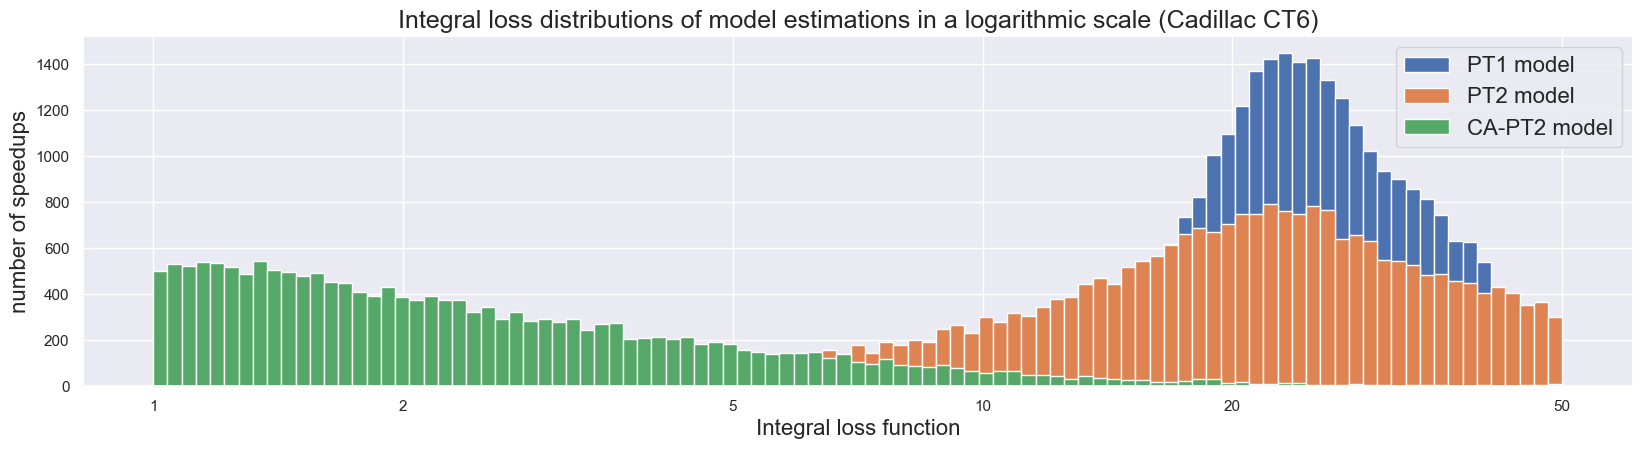

In [106]:
from matplotlib.ticker import  ScalarFormatter
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = [20, 10]
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.set_xscale('log')
#ax.xaxis.set_ticks(np.logspace(start=np.log10(1), stop=np.log10(50), num=20, base=10))
ax.set_xticks([1.0,2.0,5.0, 10.0, 20.0,50.0])
ax.get_xaxis().set_major_formatter(ScalarFormatter())
ax.hist(pt1_losses, bins=np.logspace(start=np.log10(1), stop=np.log10(50), num=100), label="PT1 model")
ax.hist(pt2_losses, bins=np.logspace(start=np.log10(1), stop=np.log10(50), num=100), label="PT2 model")
ax.hist(ca_pt2_losses, bins=np.logspace(start=np.log10(1), stop=np.log10(50), num=100), label="CA-PT2 model")
plt.xlabel("Integral loss function", fontsize=16)
plt.ylabel("number of speedups", fontsize=16)
plt.title("Integral loss distributions of model estimations in a logarithmic scale (Cadillac CT6)", fontsize=18)
ax.legend(fontsize=16)
plt.show()